In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore

# Load the data
data = pd.read_csv('london_dataset.csv')

# Convert the 'datetime' column to datetime data type
data['datetime'] = pd.to_datetime(data['datetime'])

# Sort the data by date
data.sort_values(by=['datetime'], inplace=True)

# Set the 'datetime' column as the index
data.set_index('datetime', inplace=True)
data.head()

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01,London,13.0,7.4,11.2,13.0,4.2,10.3,9.5,89.5,8.615,...,0.9,1,NaN,2012-01-01T08:06:18,2012-01-01T16:01:32,0.25,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03660099999,03672099999,0378109999..."
2012-01-02,London,7.8,4.3,6.0,5.0,0.8,2.8,2.8,80.8,10.933,...,2.8,2,NaN,2012-01-02T08:06:12,2012-01-02T16:02:35,0.28,"Rain, Partially cloudy",Partly cloudy throughout the day with rain cle...,rain,"03769099999,03660099999,03672099999,0378109999..."
2012-01-03,London,12.5,5.8,8.9,12.5,2.2,6.1,5.9,82.0,8.417,...,1.2,1,NaN,2012-01-03T08:06:03,2012-01-03T16:03:41,0.31,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03660099999,03672099999,0378109999..."
2012-01-04,London,9.6,5.3,7.2,5.2,0.8,3.1,3.5,77.5,0.000,...,1.7,1,NaN,2012-01-04T08:05:51,2012-01-04T16:04:49,0.35,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03660099999,03672099999,0378109999..."
2012-01-05,London,11.6,7.5,9.9,11.6,4.1,8.5,4.3,68.6,4.584,...,3.7,2,NaN,2012-01-05T08:05:35,2012-01-05T16:06:00,0.38,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03660099999,03672099999,0378109999..."


# Linear Regression Temp 1

Mean Absolute Error: 1.42
Mean Squared Error: 3.39
Root Mean Squared Error: 1.84


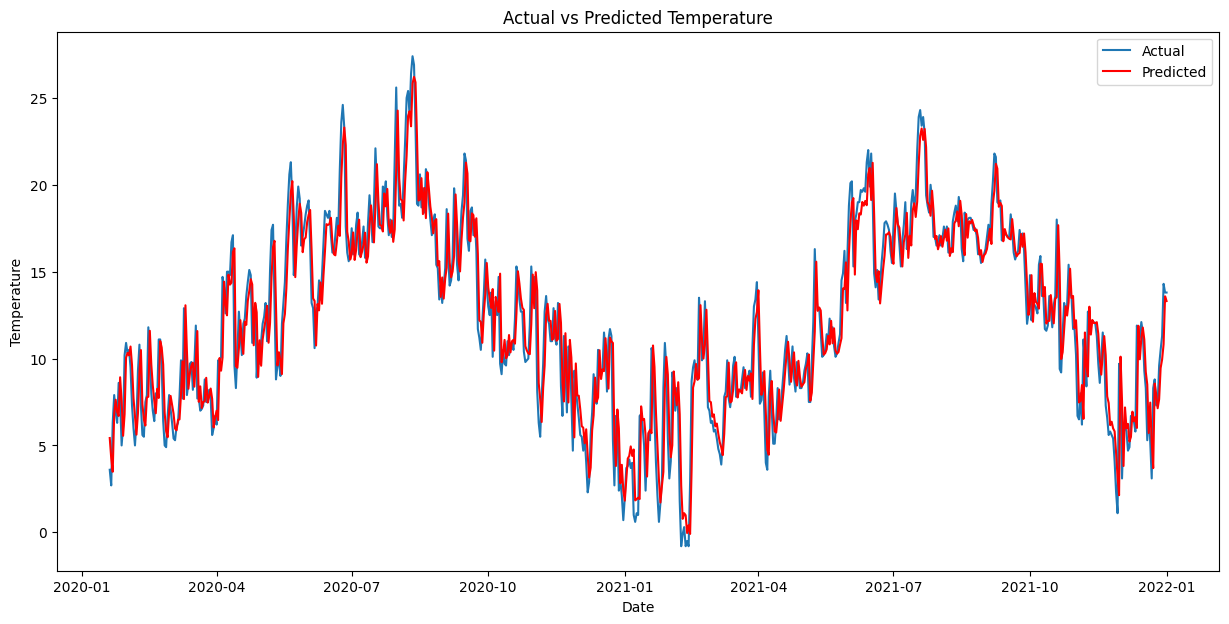

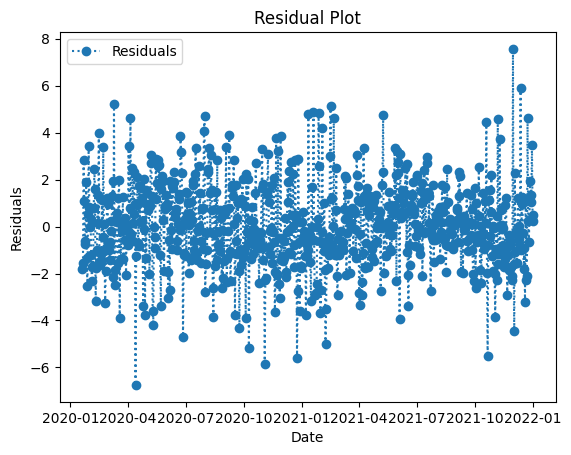

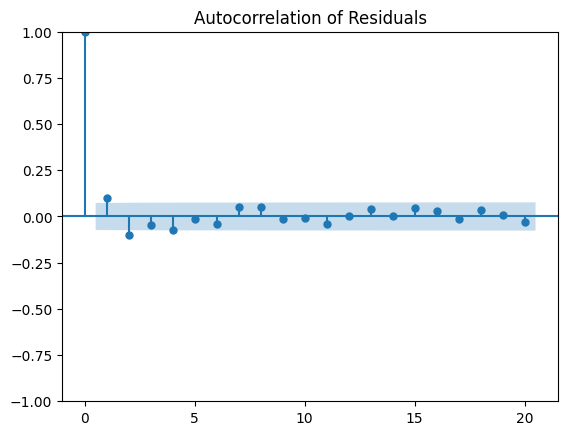

In [3]:
# Create lag features
def create_lag_features(df, lag_features, n_lags):
    df = df.copy()
    for feature in lag_features:
        for lag in range(1, n_lags+1):
            df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df

# Add lag features for temperature
n_lags = 3
data = create_lag_features(data, ['temp'], n_lags)

# Add rolling window features
data['rolling_mean_temp'] = data['temp'].rolling(window=90).mean()

# Add date-related features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['day_of_year'] = data.index.dayofyear

# Drop rows with NaN values created by lag features and rolling window features
nan_columns = [f"temp_lag{i}" for i in range(1, n_lags+1)] + ['rolling_mean_temp']
data.dropna(subset=nan_columns, inplace=True)


# Define the target variable and feature set
target = 'temp'
features = [f"temp_lag{i}" for i in range(1, n_lags+1)] + ['rolling_mean_temp', 'day_of_week', 'month', 'day_of_year']

X = data[features]
y = data[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Plot actual vs. predicted values
plt.figure(figsize=(15, 7))  # Increase the figure size
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


# Residual diagnostics
residuals = y_test - y_pred
plt.figure()
plt.plot(y_test.index, residuals, label='Residuals', linestyle=':', marker='o')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

# Autocorrelation plot of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()

# Ridge Regression Temp

Best alpha value: 0.0001
Mean Absolute Error: 1.42
Mean Squared Error: 3.41
Root Mean Squared Error: 1.85


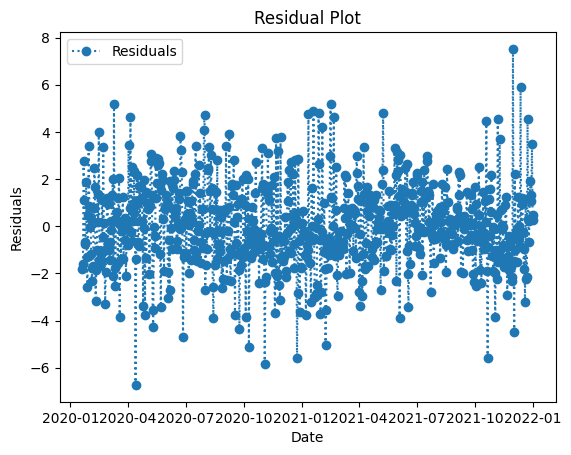

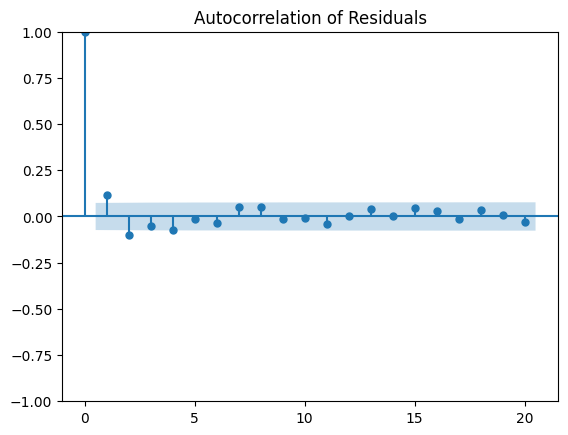

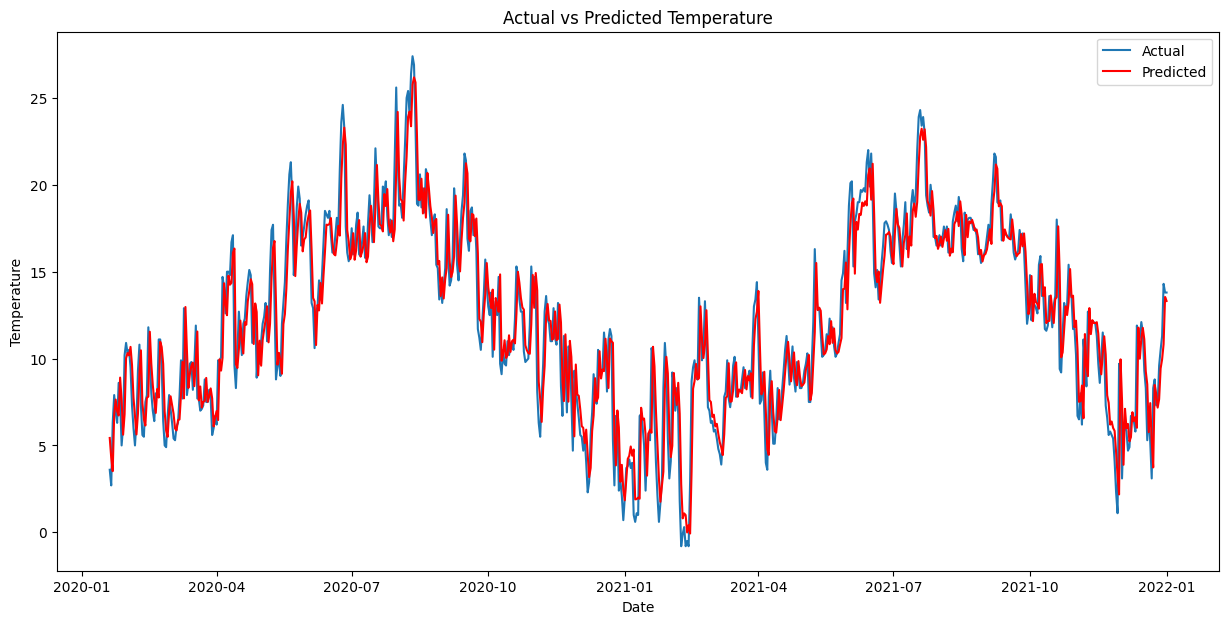

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf


# Load the data
data = pd.read_csv('london_dataset.csv')

# Convert the 'datetime' column to datetime data type
data['datetime'] = pd.to_datetime(data['datetime'])

# Sort the data by date
data.sort_values(by=['datetime'], inplace=True)

# Set the 'datetime' column as the index
data.set_index('datetime', inplace=True)


# Your existing data loading and preprocessing code here
# Create lag features
def create_lag_features(df, lag_features, n_lags):
    df = df.copy()
    for feature in lag_features:
        for lag in range(1, n_lags+1):
            df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df



# Create date-related features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['day_of_year'] = data.index.dayofyear

# Add more lag features
n_lags = 7
data = create_lag_features(data, ['temp'], n_lags)

# Add rolling mean
data['rolling_mean_temp'] = data['temp'].rolling(window=7).mean()

# Add rolling standard deviation
data['rolling_std_temp'] = data['temp'].rolling(window=7).std()

# Drop rows with NaN values
nan_columns = [f"temp_lag{i}" for i in range(1, n_lags+1)] + ['rolling_mean_temp', 'rolling_std_temp']
data.dropna(subset=nan_columns, inplace=True)

# Update the features list
features = [f"temp_lag{i}" for i in range(1, n_lags+1)] + ['rolling_mean_temp', 'rolling_std_temp', 'day_of_week', 'month', 'day_of_year']

X = data[features]
y = data[target]

# Time series cross-validation using Ridge regression and hyperparameter tuning
tscv = TimeSeriesSplit(n_splits=5)
ridge_cv = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=tscv, scoring='neg_mean_squared_error')
ridge_cv.fit(X, y)

# Best alpha value
best_alpha = ridge_cv.alpha_
print(f"Best alpha value: {best_alpha}")

# Train Ridge regression model with the best alpha value
ridge_model = ridge_cv
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Residual diagnostics
residuals = y_test - y_pred
plt.figure()
plt.plot(y_test.index, residuals, label='Residuals', linestyle=':', marker='o')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

# Autocorrelation plot of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()

# Plot actual vs. predicted values
plt.figure(figsize=(15, 7))  # Increase the figure size
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


# Linear Regression Temp 2

Mean Absolute Error: 0.00 (±0.00)
Mean Squared Error: 0.00 (±0.00)
Root Mean Squared Error: 0.00 (±0.00)


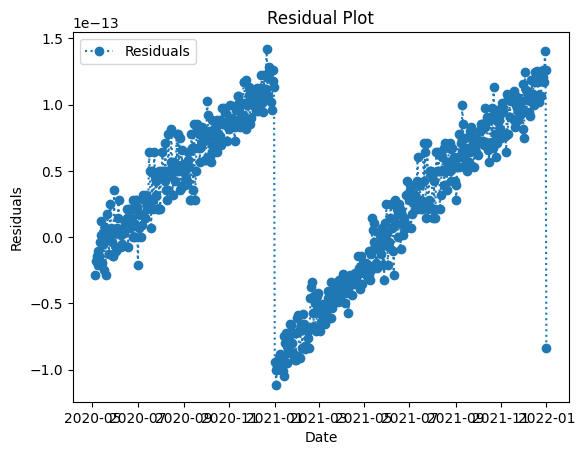

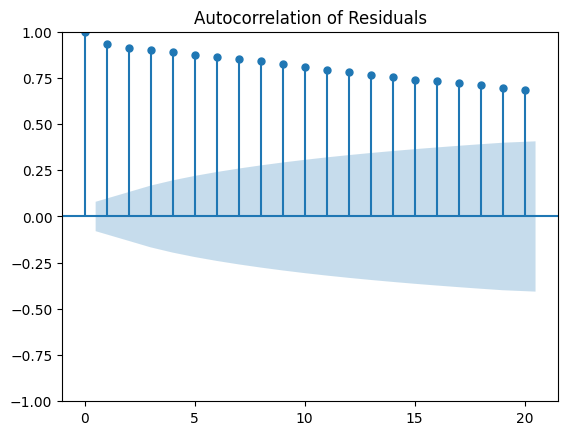

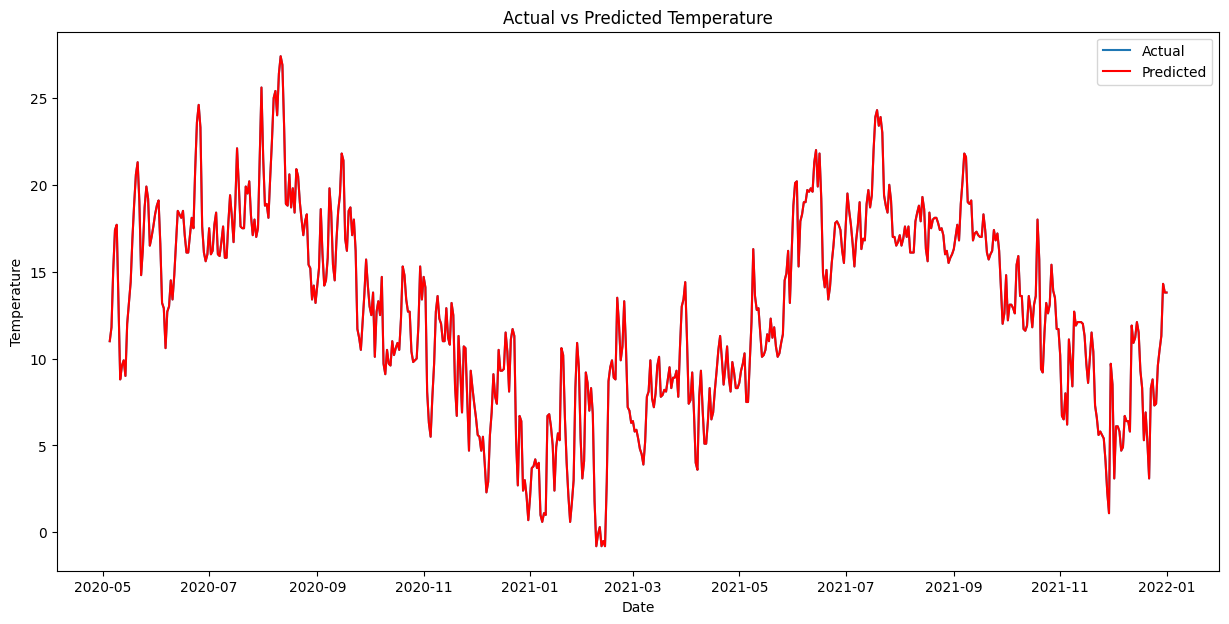

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf


# Load the data
data = pd.read_csv('london_dataset.csv')

# Convert the 'datetime' column to datetime data type
data['datetime'] = pd.to_datetime(data['datetime'])

# Sort the data by date
data.sort_values(by=['datetime'], inplace=True)

# Set the 'datetime' column as the index
data.set_index('datetime', inplace=True)


# Your existing data loading and preprocessing code here
# Create lag features
def create_lag_features(df, lag_features, n_lags):
    df = df.copy()
    for feature in lag_features:
        for lag in range(1, n_lags+1):
            df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df

# Create date-related features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['day_of_year'] = data.index.dayofyear

# Add more lag features
n_lags = 7
data = create_lag_features(data, ['temp'], n_lags)

# Add rolling mean
data['rolling_mean_temp'] = data['temp'].rolling(window=7).mean()

# Add rolling standard deviation
data['rolling_std_temp'] = data['temp'].rolling(window=7).std()

# Drop rows with NaN values
nan_columns = [f"temp_lag{i}" for i in range(1, n_lags+1)] + ['rolling_mean_temp', 'rolling_std_temp']
data.dropna(subset=nan_columns, inplace=True)

# Update the features list
features = [f"temp_lag{i}" for i in range(1, n_lags+1)] + ['rolling_mean_temp', 'rolling_std_temp', 'day_of_week', 'month', 'day_of_year']

X = data[features]
y = data[target]

# Time series cross-validation using Linear Regression
tscv = TimeSeriesSplit(n_splits=5)
maes = []
mses = []
rmses = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)

# Calculate mean and standard deviation of evaluation metrics across cross-validation splits
mean_mae = np.mean(maes)
std_mae = np.std(maes)
mean_mse = np.mean(mses)
std_mse = np.std(mses)
mean_rmse = np.mean(rmses)
std_rmse = np.std(rmses)

print(f"Mean Absolute Error: {mean_mae:.2f} (±{std_mae:.2f})")
print(f"Mean Squared Error: {mean_mse:.2f} (±{std_mse:.2f})")
print(f"Root Mean Squared Error: {mean_rmse:.2f} (±{std_rmse:.2f})")

# Residual diagnostics
residuals = y_test - y_pred
plt.figure()
plt.plot(y_test.index, residuals, label='Residuals', linestyle=':', marker='o')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

# Autocorrelation plot of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()

# Plot actual vs. predicted values
plt.figure(figsize=(15, 7))  # Increase the figure size
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()


# Linear Regression Humidity 1

Mean Absolute Error: 5.16
Mean Squared Error: 43.30
Root Mean Squared Error: 6.58


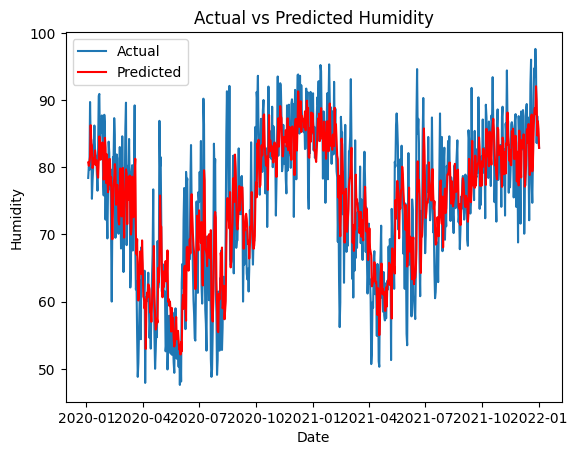

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf


# Load the data
data = pd.read_csv('london_dataset.csv')

# Convert the 'datetime' column to datetime data type
data['datetime'] = pd.to_datetime(data['datetime'])

# Sort the data by date
data.sort_values(by=['datetime'], inplace=True)

# Set the 'datetime' column as the index
data.set_index('datetime', inplace=True)


# Function to create lag features
def create_lag_features(df, lag_features, n_lags):
    df = df.copy()
    for feature in lag_features:
        for lag in range(1, n_lags + 1):
            df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df

# Create date-related features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['day_of_year'] = data.index.dayofyear

# Add more lag features
n_lags = 7
data = create_lag_features(data, ['humidity'], n_lags)

# Add rolling mean
data['rolling_mean_humidity'] = data['humidity'].rolling(window=14).mean()

# Add rolling standard deviation
data['rolling_std_humidity'] = data['humidity'].rolling(window=14).std()

# Drop rows with NaN values
nan_columns = [f"humidity_lag{i}" for i in range(1, n_lags + 1)] + ['rolling_mean_humidity', 'rolling_std_humidity']
data.dropna(subset=nan_columns, inplace=True)

# Update the features list
features = [f"humidity_lag{i}" for i in range(1, n_lags + 1)] + ['rolling_mean_humidity', 'rolling_std_humidity', 'day_of_week', 'month', 'day_of_year']

# Define target variable
target = 'humidity'

X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Plot actual vs predicted values
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()
plt.show()

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from itertools import combinations

# Load the data
data = pd.read_csv('london_dataset.csv')

# Convert the 'datetime' column to datetime data type
data['datetime'] = pd.to_datetime(data['datetime'])

# Sort the data by date
data.sort_values(by=['datetime'], inplace=True)

# Set the 'datetime' column as the index
data.set_index('datetime', inplace=True)

# Define the target variable
target = 'humidity'


# Define the list of date-related features
date_features = ['day_of_week', 'month', 'day_of_year']

# Generate all possible combinations of date-related features
date_feature_combinations = []
for i in range(1, len(date_features) + 1):
    date_feature_combinations.extend(list(combinations(date_features, i)))

best_rmse = float('inf')
best_params = None
best_date_features = None

max_lags = 7
max_windows = 8



for date_feature_combo in date_feature_combinations:
    for lag in range(1, max_lags + 1):
        for window in range(1, max_windows + 1):
            # Add lag and rolling window features
            data_temp = create_lag_features(data, ['humidity'], lag)
            data_temp['rolling_mean_humidity'] = data_temp['humidity'].rolling(window=window).mean()
            data_temp['rolling_std_humidity'] = data_temp['humidity'].rolling(window=window).std()
            data_temp.dropna(subset=[f"humidity_lag{i}" for i in range(1, lag + 1)] + ['rolling_mean_humidity', 'rolling_std_humidity'], inplace=True)
            
            # Add date-related features
            for feature in date_feature_combo:
                data_temp[feature] = getattr(data_temp.index, feature)

            # Update the features list
            features = [f"humidity_lag{i}" for i in range(1, lag + 1)] + ['rolling_mean_humidity', 'rolling_std_humidity'] + list(date_feature_combo)
            X = data_temp[features]
            y = data_temp[target]

            # Time series cross-validation
            tscv = TimeSeriesSplit(n_splits=5)

            rmses = []
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                # Train Linear Regression model
                lr_model = LinearRegression()
                lr_model.fit(X_train, y_train)

                # Make predictions on the test set
                y_pred = lr_model.predict(X_test)

                # Evaluate the model
                rmse = sqrt(mean_squared_error(y_test, y_pred))

                rmses.append(rmse)

            # Calculate the mean RMSE across cross-validation splits
            mean_rmse = np.mean(rmses)

            # Update the best parameters if necessary
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {'lag': lag, 'window': window}
                best_date_features = date_feature_combo

print(f"Best RMSE: {best_rmse:.2f}")
print(f"Best parameters: {best_params}")
print(f"Best date-related features: {best_date_features}")

# Use the best parameters and date-related features for feature engineering
best_lag = best_params['lag']
best_window = best_params['window']

data = create_lag_features(data, ['humidity'], best_lag)
data['rolling_mean_humidity'] = data['humidity'].rolling(window=best_window).mean()
data['rolling_std_humidity'] = data['humidity'].rolling(window=best_window).std()

for feature in best_date_features:
    data[feature] = getattr(data.index, feature)

nan_columns = [f"humidity_lag{i}" for i in range(1, best_lag + 1)] + ['rolling_mean_humidity', 'rolling_std_humidity']
data.dropna(subset=nan_columns, inplace=True)

# Update the features list
features = [f"humidity_lag{i}" for i in range(1, best_lag + 1)] + ['rolling_mean_humidity', 'rolling_std_humidity'] + list(best_date_features)

X = data[features]
y = data[target]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
maes = []
mses = []
rmses = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)

# Calculate mean and standard deviation of evaluation metrics across cross-validation splits
mean_mae = np.mean(maes)
std_mae = np.std(maes)
mean_mse = np.mean(mses)
std_mse = np.std(mses)
mean_rmse = np.mean(rmses)
std_rmse = np.std(rmses)

print(f"Mean Absolute Error: {mean_mae:.2f} (±{std_mae:.2f})")
print(f"Mean Squared Error: {mean_mse:.2f} (±{std_mse:.2f})")
print(f"Root Mean Squared Error: {mean_rmse:.2f} (±{std_rmse:.2f})")

plt.figure(figsize=(15, 7)) # Increase the figure size
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()
plt.show()

ValueError: Cannot have number of folds=6 greater than the number of samples=0.